# Design discussions LDA Mallet Implementation

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
SO_tag_filtered_nocode = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/clean_compl_data4.csv")
SO_tag_filtered_nocode = SO_tag_filtered_nocode.loc[SO_tag_filtered_nocode['label'] == 2]  # select only bugs records
SO_tag_filtered_nocode.head()

Unnamed: 0                                               text  label
7            7  proposal load translation lazy load scope with...      2
11          11  null json exporter row left bool array test co...      2
14          14  collection provider support pagination would h...      2
16          16  error debian can not read property undefined w...      2
50          50  perform update animated always necessary data ...      2

In [ ]:
#checkpoint
#save csv with limited columns
SO_tag_filtered_nocode['Id'] = SO_tag_filtered_nocode.index
SO_tag_filtered_nocode.to_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_text_processed.csv", columns=['Id','text'],index=False)

In [ ]:
SO_tag_filtered_nocode = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_text_processed.csv")
SO_tag_filtered_nocode.head()

Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    text
0  7   proposal load translation lazy load scope with translation php public function load translation return load translation function relation query use fall back locale locale country fall back locale get fall back locale locale locale array unique locale country fall back locale get fall back locale return query wherein get translation table getlocale key locale return query get translation table getlocale key locale may could php public function load translation query new query without relationship with translation query eager load relation return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  11  null json exporter row left bool array test column name bool array test ordinal position type null false auto increment false value null bool test column name bool test ordinal position type null false auto increment false value null right null case right appropriate left list                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2  14  collection provider support pagination would helpful support pagination could added http ravel like able use eloquent model without needing load full dataset table                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

# dataset visualizations

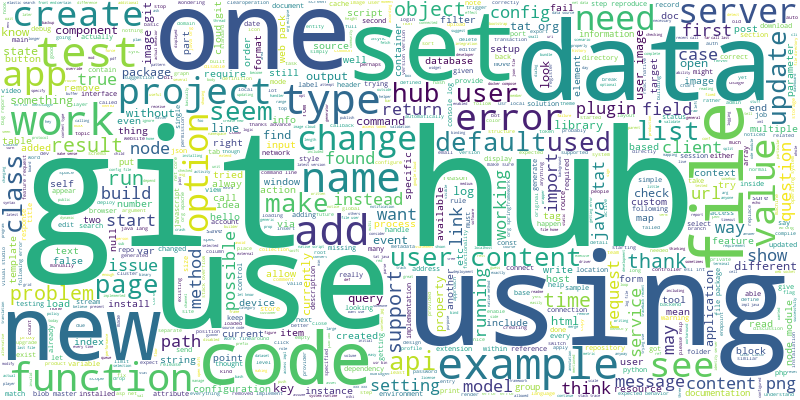

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(SO_tag_filtered_nocode['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

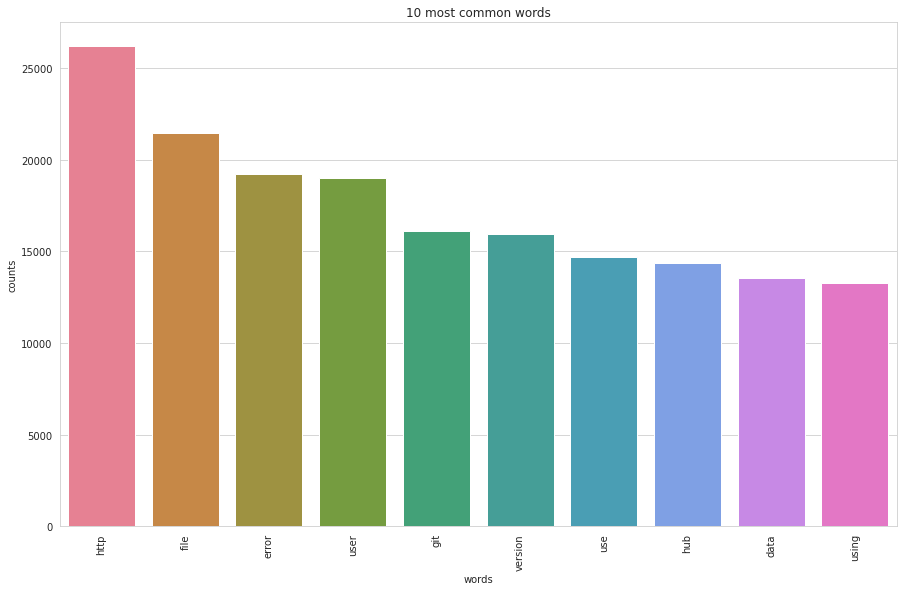

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(SO_tag_filtered_nocode['text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# sklearn default implementation of LDA Mallet

In [ ]:
#benchmark - no need to run
# the sklearn default implementation of LDAMallet
%%time

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, verbose = True)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topics found via LDA:

Topic #0:
data type value function error return object string message new

Topic #1:
use http like file module component code issue using git

Topic #2:
java service server org tat client docker com exception error

Topic #3:
http user git hub image issue version content using com

Topic #4:
file error package build test line version module run lib
CPU times: user 6.92 s, sys: 663 ms, total: 7.58 s
Wall time: 7min 41s


# Generating bi-grams and tri-grams

In [ ]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

data_words = list(sent_to_words(SO_tag_filtered_nocode.text))

print(data_words[:1])

[['proposal', 'load', 'translation', 'lazy', 'load', 'scope', 'with', 'translation', 'php', 'public', 'function', 'load', 'translation', 'return', 'load', 'translation', 'function', 'relation', 'query', 'use', 'fall', 'back', 'locale', 'locale', 'country', 'fall', 'back', 'locale', 'get', 'fall', 'back', 'locale', 'locale', 'locale', 'array', 'unique', 'locale', 'country', 'fall', 'back', 'locale', 'get', 'fall', 'back', 'locale', 'return', 'query', 'wherein', 'get', 'translation', 'table', 'getlocale', 'key', 'locale', 'return', 'query', 'get', 'translation', 'table', 'getlocale', 'key', 'locale', 'may', 'could', 'php', 'public', 'function', 'load', 'translation', 'query', 'new', 'query', 'without', 'relationship', 'with', 'translation', 'query', 'eager', 'load', 'relation', 'return']]


In [ ]:
#checkpoint 

import pickle
#pickle.dump(data_words,'/content/drive/MyDrive/Research/ICSME 2021/SO_data_words.pkl')

#saving data words
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_words.pkl', 'wb') as handle:
    pickle.dump(data_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!pip install pyLDAvis

#frm here

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#opening saved data words.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_words.pkl', 'rb') as handle:
    data_words = pickle.load(handle)
# data_words

In [ ]:
import pyLDAvis
# import pyLDAvis.gensim_models
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# checkpoint
bigram_mod.save('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_bigram_mod')
trigram_mod.save('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_trigram_mod')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packa

In [ ]:
# LOAD
bigram_mod = gensim.models.phrases.Phraser.load('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_bigram_mod')
trigram_mod = gensim.models.phrases.Phraser.load('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_trigram_mod')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


# lemmetization

In [ ]:
# stopwords
import nltk 
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']
import re

data_processed = []
stop_words = nltk.corpus.stopwords.words('english')

# bi-gram and tri-gram implementation
texts = [bigram_mod[doc] for doc in data_words]
texts = [trigram_mod[bigram_mod[doc]] for doc in data_words]

texts_out = []
# implement lemmatization and filter out unwanted part of speech tags
for sent in texts:
  doc = nlp(" ".join(sent)) 
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
# remove stopwords and short tokens again after lemmatization
texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out] 

data_ready = texts_out
data_ready

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

[['proposal',
  'load',
  'translation',
  'lazy',
  'load',
  'scope',
  'translation',
  'public',
  'function',
  'load',
  'translation',
  'return',
  'load',
  'translation',
  'function',
  'relation',
  'use',
  'country',
  'locale',
  'get',
  'locale',
  'locale',
  'get',
  'locale',
  'return',
  'query',
  'wherein',
  'get',
  'translation',
  'table',
  'getlocale',
  'key',
  'locale',
  'return',
  'query',
  'get',
  'translation',
  'table',
  'getlocale',
  'key',
  'locale',
  'may',
  'could',
  'php',
  'public',
  'function',
  'load',
  'translation',
  'query',
  'new',
  'query',
  'relationship',
  'translation',
  'eager',
  'load',
  'relation',
  'return'],
 ['leave',
  'column',
  'name',
  'ordinal',
  'position',
  'type',
  'null',
  'false',
  'auto_increment',
  'false',
  'value',
  'test',
  'column',
  'name',
  'ordinal',
  'position',
  'type',
  'null',
  'false',
  'auto_increment',
  'false',
  'value',
  'null',
  'right',
  'null',
  'cas

In [ ]:
# from nltk.stem import WordNetLemmatizer

# wnl = WordNetLemmatizer()
# data_processed = []
# stop_words = nltk.corpus.stopwords.words('english')
# for doc in data_words:
#     doc_out = []
#     for wd in doc:
#         if wd not in stop_words:  # remove stopwords
#             lemmatized_word = ""
#             lemmatized_word = wnl.lemmatize(wd)  # lemmatize
#             if lemmatized_word:
#                 doc_out.append(lemmatized_word)
#         else:
#             continue
#     data_processed.append(doc_out)
# data_ready = data_processed


In [ ]:
#checkpoint
#saving lemmetize
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_ready.pkl', 'wb') as handle:
    pickle.dump(data_ready, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_ready.pkl', 'rb') as handle:
    data_ready = pickle.load(handle)
# data_ready

# vocabulary

In [ ]:
# print vocab
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 26952


In [ ]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# checkpoint
# saving corpus
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_corpus.pkl', 'wb') as handle:
    pickle.dump(corpus, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_corpus.pkl', 'rb') as handle:
    corpus = pickle.load(handle)

In [ ]:
import pandas as pd
# creating a dictionary corpus
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

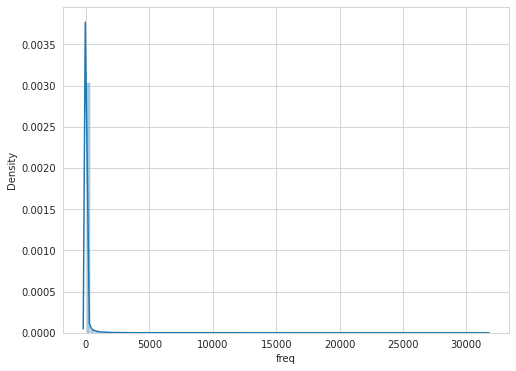

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [ ]:
dict_df.sort_values('freq', ascending=False).head(10)

freq
use      31578
file     20749
error    16076
get      15357
user     14725
http     13476
version  13221
work     13058
run      12000
issue    11960

In [ ]:
# !pip install --upgrade pip

In [ ]:
extension = dict_df[dict_df.freq>5000].index.tolist()

In [ ]:
#checkpoint
#saving extension
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_extension.pkl', 'wb') as handle:
    pickle.dump(extension, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_extension.pkl', 'rb') as handle:
    extension = pickle.load(handle)

In [ ]:
# to filter words greater then 1500 freq 
ids=[id2word.token2id[extension[i]] for i in range(len(extension))]
id2word.filter_tokens(bad_ids=ids)

# removing stopwords and outliers and frequent words to reduce vocabulary

In [ ]:
#here look for nouns, verbs .... 

import nltk
stop_words = nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
# add high frequency words to stop words list
stop_words.extend(extension)
wnl = WordNetLemmatizer()
data_processed = []
for doc in data_words:
    doc_out = []
    for wd in doc:
        if wd not in stop_words:  # remove stopwords
            lemmatized_word = ""
            lemmatized_word = wnl.lemmatize(wd)  # lemmatize
            if lemmatized_word:
                doc_out.append(lemmatized_word)
        else:
            continue
    data_processed.append(doc_out)
data_ready = data_processed

In [ ]:
data_ready

[['proposal',
  'load',
  'translation',
  'lazy',
  'load',
  'scope',
  'translation',
  'php',
  'public',
  'load',
  'translation',
  'load',
  'translation',
  'relation',
  'query',
  'fall',
  'back',
  'locale',
  'locale',
  'country',
  'fall',
  'back',
  'locale',
  'fall',
  'back',
  'locale',
  'locale',
  'locale',
  'array',
  'unique',
  'locale',
  'country',
  'fall',
  'back',
  'locale',
  'fall',
  'back',
  'locale',
  'query',
  'wherein',
  'translation',
  'table',
  'getlocale',
  'key',
  'locale',
  'query',
  'translation',
  'table',
  'getlocale',
  'key',
  'locale',
  'php',
  'public',
  'load',
  'translation',
  'query',
  'query',
  'without',
  'relationship',
  'translation',
  'query',
  'eager',
  'load',
  'relation'],
 ['null',
  'json',
  'exporter',
  'row',
  'left',
  'bool',
  'array',
  'column',
  'bool',
  'array',
  'ordinal',
  'position',
  'null',
  'false',
  'auto',
  'increment',
  'false',
  'null',
  'bool',
  'column',
  '

In [ ]:
#checkpoint
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_ready_last.pkl', 'wb') as handle:
    pickle.dump(data_ready, handle, protocol=pickle.HIGHEST_PROTOCOL)

#here2

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_ready_last.pkl', 'rb') as handle:
    data_ready = pickle.load(handle)

In [ ]:
# recreate Dictionary
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 42115


In [ ]:
# Filter out words that occur less than 10 documents, or more than
# 50% of the documents.
id2word.filter_extremes(no_below=20, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 5675


In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
#checkpoint
# saving corpus
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_corpus.pkl', 'wb') as handle:
    pickle.dump(corpus, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_corpus.pkl', 'rb') as handle:
    corpus = pickle.load(handle)

# installing mallet optimizer

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-09-13 04:45:21--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  14.3MB/s    in 1.1s    

2021-09-13 04:45:22 (14.3 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'

# Training the model and optimizing the number of topics 

In [ ]:
%%time
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

CPU times: user 21 µs, sys: 1 µs, total: 22 µs
Wall time: 27.7 µs


In [ ]:
from tqdm import tqdm
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
   
   # https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
#training
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit= 70, step=5) 

100%|██████████| 14/14 [1:12:03<00:00, 308.80s/it]

CPU times: user 14min 38s, sys: 11.1 s, total: 14min 49s
Wall time: 1h 12min 3s


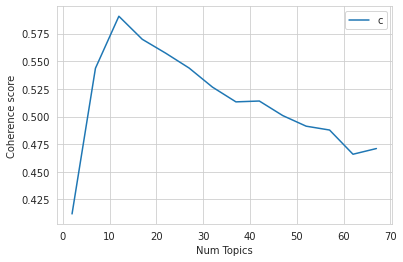

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Show graph
limit=70; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4119
Num Topics = 7  has Coherence Value of 0.5437
Num Topics = 12  has Coherence Value of 0.5907
Num Topics = 17  has Coherence Value of 0.5699
Num Topics = 22  has Coherence Value of 0.5573
Num Topics = 27  has Coherence Value of 0.5439
Num Topics = 32  has Coherence Value of 0.5266
Num Topics = 37  has Coherence Value of 0.5133
Num Topics = 42  has Coherence Value of 0.5141
Num Topics = 47  has Coherence Value of 0.5009
Num Topics = 52  has Coherence Value of 0.4913
Num Topics = 57  has Coherence Value of 0.4878
Num Topics = 62  has Coherence Value of 0.4659
Num Topics = 67  has Coherence Value of 0.4711


# optimal model generation

In [ ]:
from pprint import pprint
# Select the model and print the topics
optimal_model = model_list[4] # change it if need for optimal topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(13,
  '0.059*"open" + 0.047*"state" + 0.032*"process" + 0.025*"command" + '
  '0.023*"job" + 0.022*"back" + 0.022*"status" + 0.021*"session" + '
  '0.014*"thread" + 0.014*"running"'),
 (15,
  '0.094*"java" + 0.058*"org" + 0.042*"tat" + 0.015*"impl" + 0.015*"internal" '
  '+ 0.014*"exception" + 0.014*"release" + 0.014*"jar" + 0.013*"lang" + '
  '0.013*"spring"'),
 (14,
  '0.041*"net" + 0.038*"core" + 0.035*"token" + 0.032*"task" + '
  '0.029*"exception" + 0.027*"access" + 0.026*"context" + 0.023*"auth" + '
  '0.019*"password" + 0.019*"login"'),
 (5,
  '0.034*"input" + 0.029*"date" + 0.028*"size" + 0.027*"number" + 0.025*"read" '
  '+ 0.023*"output" + 0.020*"format" + 0.018*"write" + 0.015*"frame" + '
  '0.014*"byte"'),
 (1,
  '0.038*"case" + 0.027*"multiple" + 0.025*"feature" + 0.019*"based" + '
  '0.017*"solution" + 0.016*"part" + 0.015*"interface" + 0.015*"specific" + '
  '0.015*"single" + 0.014*"implementation"'),
 (7,
  '0.037*"install" + 0.028*"python" + 0.028*"lib" + 0.024*"loca

In [ ]:
#checkpoint
import pickle
pickle.dump(optimal_model, open("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_ldamallet_topics.pkl", "wb"))

# save the optimal model

In [ ]:
import pandas as pd

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
ldamallet_14 = pickle.load(open("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_ldamallet_topics.pkl", "rb"))

In [ ]:
tm_results = ldamallet_14[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet_14.show_topic(n, topn=20)] for n in range(0, ldamallet_14.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet_14.num_topics+1)]).T
topics_df.head()

Topic 1   Topic 2  Topic 3  ... Topic 20 Topic 21 Topic 22
Term1  content      case      app  ...      key    thing      log
Term2    cloud  multiple  android  ...   string     good    event
Term3      png   feature  library  ...     json     idea      php
Term4     link     based   plugin  ...   public      lot  setting
Term5      tag  solution   google  ...      map  thought  console

[5 rows x 22 columns]

In [ ]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet_14.num_topics+1)] )
topics_df

Terms per Topic
Topic1   content, cloud, png, link, tag, stream, folder, video, load, download, player, upload, source, demo, medium, show, zip, track, play, jpg                                                    
Topic2   case, multiple, feature, based, solution, part, interface, specific, single, implementation, implement, unit, testing, separate, current, side, structure, existing, approach, functionality
Topic3   app, android, library, plugin, google, device, push, platform, application, sdk, sample, notification, framework, working, activity, plugins, apps, phone, swift, manager                   
Topic4   window, order, variable, bit, extension, language, product, entry, foo, bar, transaction, working, limit, missing, match, supported, print, visual, studio, sharp                           
Topic5   docker, container, instance, resource, host, info, aws, running, root, driver, storage, machine, environment, cluster, agent, network, configuration, che, volume, var                      
Topic6   input, date, size, number, read, output, format, write, frame, byte, memory, buffer, max, flow, range, length, int, camera, real, rate                                                      
Topic7   point, element, box, label, level, tool, chart, editor, space, top, display, height, width, drop, position, layer, left, figure, word, original                                             
Topic8   install, python, lib, local, directory, home, linux, bin, usr, command, installed, warning, found, program, failed, dir, target, include, src, cpp                                          
Topic9   api, url, post, response, html, header, template, send, site, custom, email, route, body, rest, grid, put, mail, working, website, chat                                                     
Topic10  module, node, component, import, react, script, const, err, export, native, angular, require, index, prop, lib, app, load, child, vue, javascript                                           
Topic11  view, text, item, form, button, action, color, click, show, icon, control, layout, tab, controller, menu, title, theme, cell, edit, screen                                                  
Topic12  step, bug, check, behavior, expected, information, report, reproduce, description, feature, provide, current, detail, actual, browser, environment, include, additional, chrome, note       
Topic13  web, path, config, source, block, pack, style, rule, loader, dev, true, end, plugin, spec, font, src, configuration, babel, front, require                                                  
Topic14  open, state, process, command, job, back, status, session, thread, running, close, switch, stop, hook, end, queue, args, loop, handle, pool                                                 
Topic15  net, core, token, task, exception, access, context, auth, password, login, account, microsoft, runtime, provider, authentication, async, role, identity, permission, scope                  
Topic16  java, org, tat, impl, internal, exception, release, jar, lang, spring, handler, factory, context, main, core, access, execute, apache, abstract, dependency                                 
Topic17  git, hub, master, doc, repo, repository, blob, comment, release, documentation, branch, tree, commit, wiki, pull, readme, guide, kit, lab, merge                                            
Topic18  connection, address, port, mode, connect, bot, socket, debug, proxy, localhost, red, domain, remote, info, false, host, xxx, ssl, channel, true                                             
Topic19  data, model, field, query, table, database, search, result, index, column, row, sql, collection, select, record, entity, store, mysql, graph, count                                         
Topic20  key, string, json, public, map, property, array, null, parameter, var, attribute, filter, reference, auto, private, location, true, parse, static, false                                    
Topic21  thing, good, id

# visualizations on optimal model

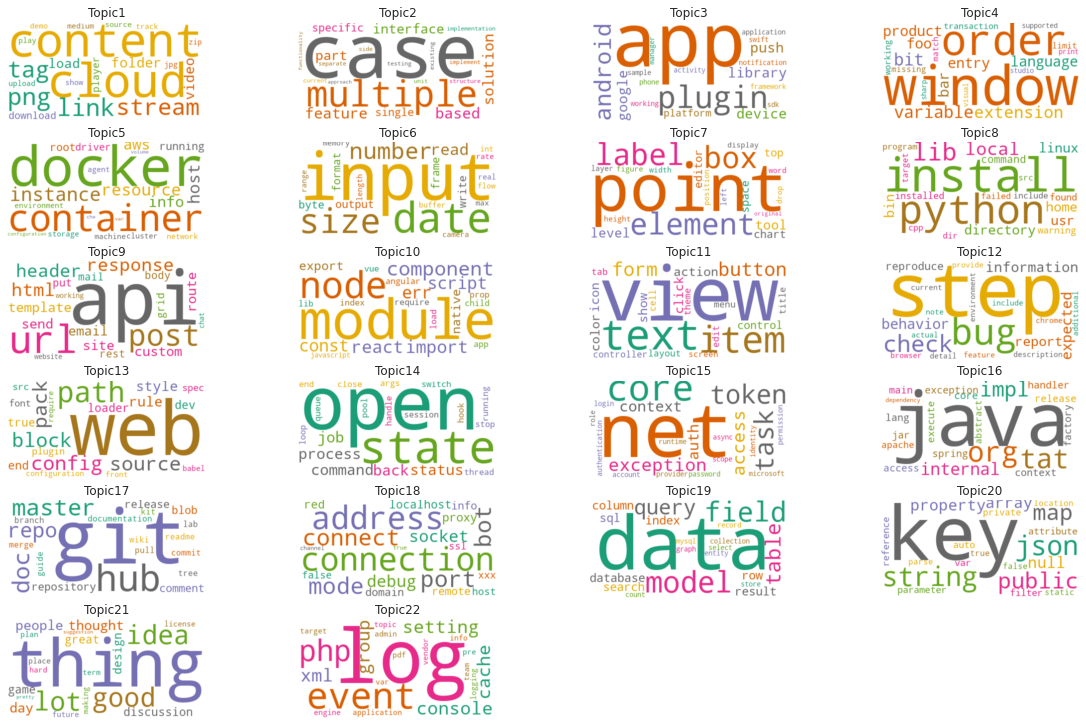

In [ ]:
# import wordclouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(22):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(7, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [ ]:
from gensim.models.ldamodel import LdaModel
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) # original function has 'eta=0' argument
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
ldagensim = convertldaMalletToldaGen(ldamallet_14)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

In [ ]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['Text'] = SO_tag_filtered_nocode.text
corpus_topic_df['Id'] = SO_tag_filtered_nocode.Id
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

Text  ...                                                                                                                                               Topic Terms
0  proposal load translation lazy load scope with translation php public function load translation return load translation function relation query use fall back locale locale country fall back locale get fall back locale locale locale array unique locale country fall back locale get fall back locale return query wherein get translation table getlocale key locale return query get translation table getlocale key locale may could php public function load translation query new query without relationship with translation query eager load relation return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ...  web, path, config, source, block, pack, style, rule, loader, dev, true, end, plugin, spec, font, src, configuration, babel, front, require              
1  null json exporter row left bool array test column name bool array test ordinal position type null false auto increment false value null bool test column name bool test ordinal position type null false auto increment false value null right null case right appropriate left list                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ...  key, string, json, public, map, property, array, null, parameter, var, attribute, filter, reference, auto, private, location, true, parse, static, false
2  collection provider support pagination would helpful support pagination could added http ravel like able use eloquent model without needing load full dataset table                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     ...  data, model, field, query, table, database, search, result, index, column, row, sql, collection, select, record, entity, store, mysql, graph, count     
3  error debian can not read property undefined would love workin

In [ ]:
#predictions file
corpus_topic_df.to_csv('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv')

In [ ]:
import numpy as np
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

Dominant Topic  Doc_Count  Total_Docs_Perc
0   1               2321       5.50           
1   2               1972       4.67           
2   3               1595       3.78           
3   4               1547       3.67           
4   5               1886       4.47           
5   6               2213       5.24           
6   7               2362       5.60           
7   8               2167       5.13           
8   9               1667       3.95           
9   10              1772       4.20           
10  11              2801       6.64           
11  12              1552       3.68           
12  13              1500       3.55           
13  14              1436       3.40           
14  15              1855       4.40           
15  16              844        2.00           
16  17              2283       5.41           
17  18              1876       4.45           
18  19              2389       5.66           
19  20              1824       4.32           
20  21              2993       7.09           
21  22              1346       3.19

<BarContainer object of 22 artists>

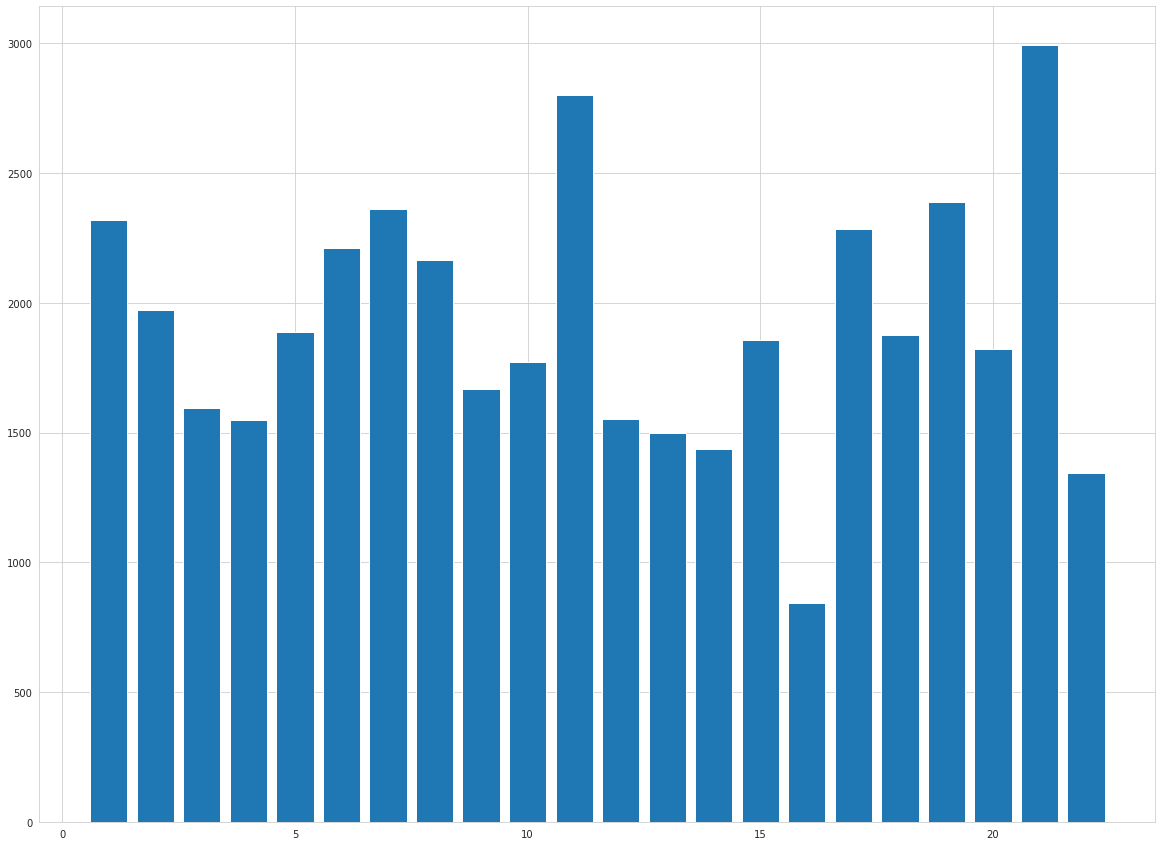

In [ ]:
plt.bar(x=dominant_topic_df['Dominant Topic'], height = dominant_topic_df['Doc_Count'])

In [ ]:
import pandas as pd
corpus_topic_df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv')

In [ ]:
corpus_topic_df.tail(20)

Unnamed: 0  ...                                                                                                                                                                                   Topic Terms
42181  42181       ...  view, text, item, form, button, action, color, click, show, icon, control, layout, tab, controller, menu, title, theme, cell, edit, screen                                                  
42182  42182       ...  net, core, token, task, exception, access, context, auth, password, login, account, microsoft, runtime, provider, authentication, async, role, identity, permission, scope                  
42183  42183       ...  view, text, item, form, button, action, color, click, show, icon, control, layout, tab, controller, menu, title, theme, cell, edit, screen                                                  
42184  42184       ...  thing, good, idea, lot, thought, people, day, discussion, great, game, design, place, license, term, plan, hard, future, making, suggestion, pretty                                         
42185  42185       ...  java, org, tat, impl, internal, exception, release, jar, lang, spring, handler, factory, context, main, core, access, execute, apache, abstract, dependency                                 
42186  42186       ...  web, path, config, source, block, pack, style, rule, loader, dev, true, end, plugin, spec, font, src, configuration, babel, front, require                                                  
42187  42187       ...  connection, address, port, mode, connect, bot, socket, debug, proxy, localhost, red, domain, remote, info, false, host, xxx, ssl, channel, true                                             
42188  42188       ...  view, text, item, form, button, action, color, click, show, icon, control, layout, tab, controller, menu, title, theme, cell, edit, screen                                                  
42189  42189       ...  api, url, post, response, html, header, template, send, site, custom, email, route, body, rest, grid, put, mail, working, website, chat                                                     
42190  42190       ...  api, url, post, response, html, header, template, send, site, custom, email, route, body, rest, grid, put, mail, working, website, chat                                                     
42191  42191       ...  case, multiple, feature, based, solution, part, interface, specific, single, implementation, implement, unit, testing, separate, current, side, structure, existing, approach, functionality
42192  42192       ...  net, core, token, task, exception, access, context, auth, password, login, account, microsoft, runtime, provider, authentication, async, role, identity, permission, scope                  
42193  42193       ...  point, element, box, label, level, tool, chart, editor, space, top, display, height, width, drop, position, layer, left, figure, word, original                                             
42194  42194       ...  app, android, library, plugin, google, device, push, platform, application, sdk, sample, notification, framework, working, activity, plugins, apps, phone, swift, manager                   
42195  42195       ...  case, multiple, feature, based, solution, part, interface, specific, single, implementation, implement, unit, testing, separate, current, side, structure, existing, approach, functionality
42196  42196       ...  install, python, lib, local, directory, home, linux, bin, usr, command, installed, warning, found, program, failed, dir, target, include, src, cpp                                          
42197  42197       ...  install, python, lib, local, directory, home, linux, bin, usr, command, installed, warning, found, program, failed, dir, target, include, src, cpp                                          
42198  42198       ...  install, python, lib, local, directory, home, linux, bin, usr, command, installed, warning, found, program, failed, dir, target, include, src, cpp   

In [ ]:
# data_src = 'SE' # SO | SE
# data_src_urls = {
#     'SO': 'stackoverflow.com',
#     'SE': 'softwareengineering.stackexchange.com'
# }
df_lda = pd.read_csv(f"/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv")
print(f"{len(df_lda.index)} rows imported.")
df_lda = df_lda[['Id', 'Text', 'Dominant Topic', 'Contribution %', 'Topic Terms']]
# df_lda.insert(1, 'URL', f"https://{data_src_urls[data_src]}/questions/" + df_lda['Id'].astype(str) + '/')
# df_lda['IsDesign'] = ""
df_lda['Label'] = ""
df_lda.head()

42201 rows imported.


Id  ... Label
0  7   ...      
1  11  ...      
2  14  ...      
3  16  ...      
4  50  ...      

[5 rows x 6 columns]

In [ ]:
#checkpoint
df_lda.to_csv('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv',index=False)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv')
test.head()

Id  ... Label
0  7   ... NaN  
1  11  ... NaN  
2  14  ... NaN  
3  16  ... NaN  
4  50  ... NaN  

[5 rows x 6 columns]

In [ ]:
top = df_lda.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False))).reset_index(drop=True)
top.head(30)

Id  ... Label
0   300742  ...      
1   241120  ...      
2   30654   ...      
3   138636  ...      
4   222234  ...      
5   400191  ...      
6   353382  ...      
7   174870  ...      
8   355721  ...      
9   149664  ...      
10  36119   ...      
11  399900  ...      
12  109841  ...      
13  360197  ...      
14  60161   ...      
15  67059   ...      
16  313646  ...      
17  305648  ...      
18  325459  ...      
19  294561  ...      
20  162242  ...      
21  253188  ...      
22  349582  ...      
23  258838  ...      
24  318459  ...      
25  247065  ...      
26  329553  ...      
27  126748  ...      
28  449429  ...      
29  241637  ...      

[30 rows x 6 columns]

In [ ]:
top.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42201 entries, 0 to 42200
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              42201 non-null  int64  
 1   Text            42201 non-null  object 
 2   Dominant Topic  42201 non-null  int64  
 3   Contribution %  42201 non-null  float64
 4   Topic Terms     42201 non-null  object 
 5   Label           42201 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.9+ MB


In [ ]:
top.to_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SO_top_answers.csv", index=False)

# generate samples of each topic for label naming




In [ ]:
lda = top.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False)))

In [ ]:
lda_1 = lda.reset_index(drop = True)

In [ ]:
lda_labelling = lda_1.groupby('Dominant Topic').head(10)
lda_labelling.tail(20)

Id  ... Label
37862  299230  ...      
37863  35462   ...      
37864  225224  ...      
37865  183929  ...      
37866  202007  ...      
37867  255887  ...      
37868  88605   ...      
37869  406374  ...      
37870  297534  ...      
37871  91492   ...      
40855  360415  ...      
40856  265603  ...      
40857  25101   ...      
40858  225553  ...      
40859  196514  ...      
40860  119427  ...      
40861  391960  ...      
40862  116199  ...      
40863  89951   ...      
40864  289742  ...      

[20 rows x 6 columns]

In [ ]:
lda_labelling.to_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_top_answers.csv", index=False)